# Tutorial 5b: Outlier detection and correction

*This tutorial was generated from an Jupyter notebook.  You can download the notebook [here](t5b_outlier_detection.ipynb).*

In [18]:
import collections
import warnings

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.stats as st

# Numba to make things faster
import numba

# The MCMC Hammer
import emcee

# Numerical differentiation package
import numdifftools as ndt

# BE/Bi 103 utilities
import bebi103

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
import corner

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Thus far when we have been doing parameter estimation, we have been making the approximation that our likelihoods are Gaussian distributed.  We appeal to the central limit theorem to do this.

I think the following quote from [David MacKay's excellent book](http://www.inference.phy.cam.ac.uk/mackay/itila/book.html) is apt.

>The Gaussian distribution is widely used and often asserted to be a very common distribution in the real world, but I am sceptical about this assertion. Yes, unimodal distributions may be common; but a Gaussian is a special, rather extreme, unimodal distribution. It has very light tails: the log- probability-density decreases quadratically. The typical deviation of $x$ from $\mu$ is $\sigma$, but the respective probabilities that $x$ deviates from $\mu$ by more than 2$\sigma$, 3$\sigma$, 4$\sigma$, and 5$\sigma$, are $\small{0.046}$, $\small{0.003}$, $\small{6\times 10^{−5}}$, and $\small{6\times 10^{−7}}$. In my experience, deviations from a mean four or five times greater than the typical deviation may be rare, but not as rare as $\small{6\times 10^{−5}}$! I therefore urge caution in the use of Gaussian distributions: if a variable that is modelled with a Gaussian actually has a heavier-tailed distribution, the rest of the model will contort itself to reduce the deviations of the outliers, like a sheet of paper being crushed by a
rubber band.

With that in mind, we might want to adjust our likelihood to account for outliers.  Otherwise, the outliers can dominate our calculation of our parameter values.  We will use to methods of outlier detection, both outlined in Sivia, though we will not exactly follow his prescription.  In the first method, Sivia's "Cauchy formulation" of section 8.3.3, assumed a Cauchy distribution (which has long tails) in the likelihood.  The second method is a variant on Sivia's "good-and-bad-data model," strongly influenced by example 2 of [this great blog post](http://jakevdp.github.io/blog/2014/06/06/frequentism-and-bayesianism-2-when-results-differ/) from Jake VanderPlas.

## Outliers in zebrafish sleep data

We will revisit the data set of Gandhi, et al., dealing with sleep in zebrafish embryos.  You may recall that we found some homozygous mutant fish that had much higher activity at night than the rest of the fish of the same genotype.  As a reminder, the original data set may be downloaded [here](../data/gandhi_et_al.zip).  We tidied the data and saved it as a CSV file.  It is probably on your machine somewhere, but if you like, you can download it [here](../data/130315_10_minute_intervals.csv).  To start with, we'll load the data into a Pandas `DataFrame` and make a strip plot of the mean activity on the third night.

In [5]:
# Load DataFrame
df = pd.read_csv('../data/gandhi_et_al/130315_10_minute_intervals.csv',
                 comment='#')

# Have a look
df.head()

,fish,genotype,day,light,CLOCK,zeit,activity
0,FISH1,het,0,True,9.819,9.819,4.500000e+00
1,FISH1,het,0,True,9.986,9.986,6.883383e-15
2,FISH1,het,0,True,10.153,10.153,6.883383e-15
3,FISH1,het,0,True,10.319,10.319,6.883383e-15
4,FISH1,het,0,True,10.486,10.486,6.883383e-15


Now, we'll compute the mean night time activity for each homozygous mutant fish on the third night.

In [9]:
# Get a view into the third night
df_n2 = df[(df['day']==2) & (df['light']==False) & (df['genotype']=='mut')]

# Compute means for each fish
mean_night_act = df_n2.groupby('fish')['activity'].mean().reset_index()
    
# Take a look
mean_night_act

,fish,activity
0,FISH11,18.618333
1,FISH12,16.846667
2,FISH13,12.160000
3,FISH20,20.585000
4,FISH21,137.593333
5,FISH23,12.718333
6,FISH27,17.456667
7,FISH35,21.406667
8,FISH39,9.705000
9,FISH4,17.283333


Fish 21 and Fish 67 might be outliers.  This is clear also when we plot the data.

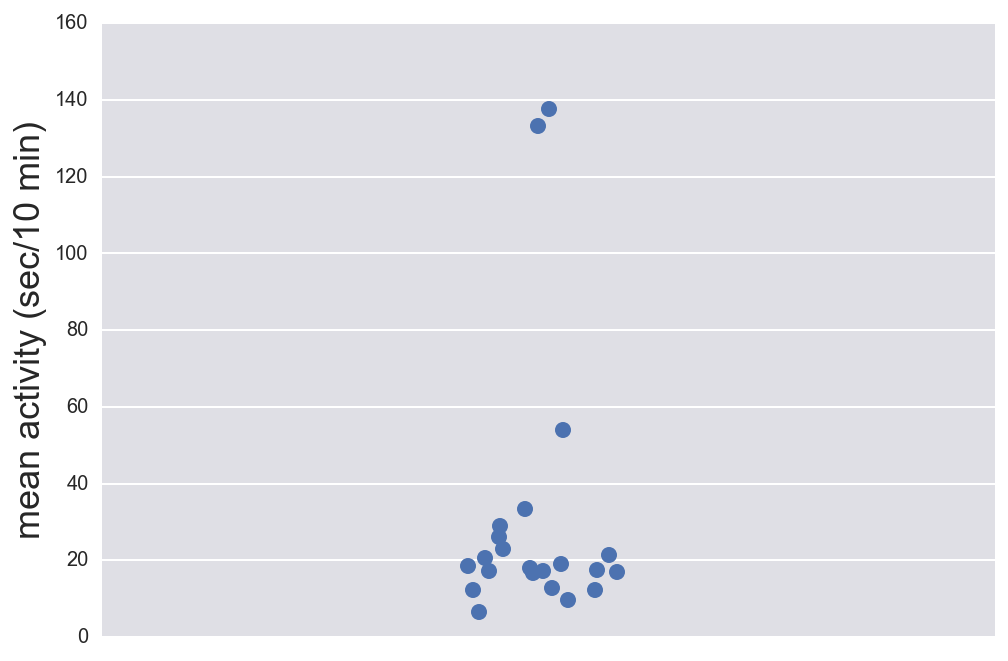

In [16]:
sns.stripplot(y='activity', data=mean_night_act, jitter=True)
plt.ylabel('mean activity (sec/10 min)');

Our goal is to compute the mean mean nighttime activity for this collection of fish (yes, I meant to say "mean" twice).  The naive way would be just to directly compute the mean, which we will show in red on the jitter plot.

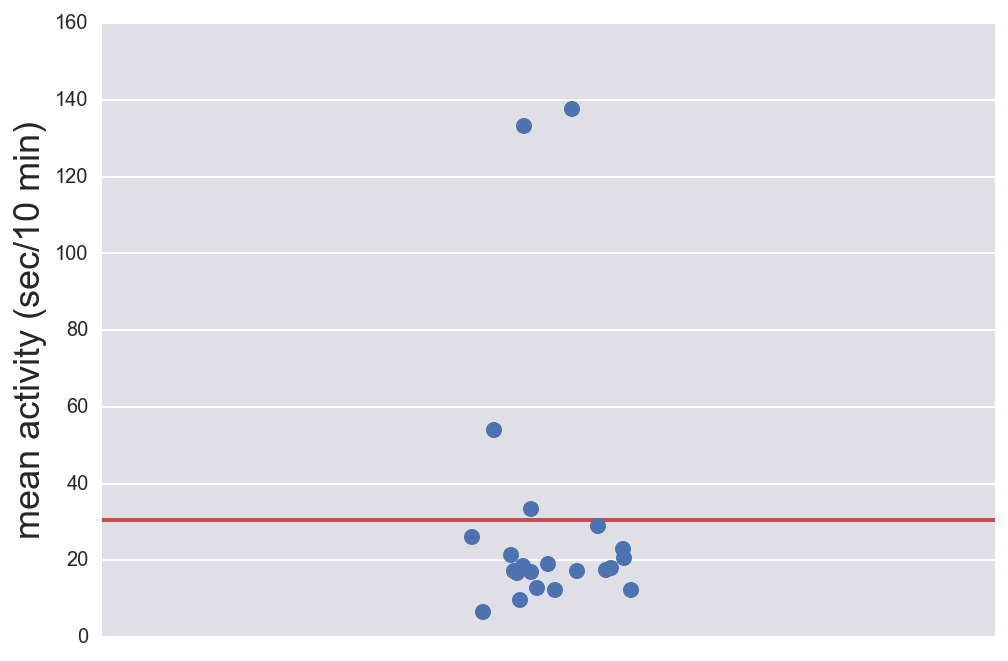

In [17]:
naive_mean = mean_night_act['activity'].mean()
sns.stripplot(y='activity', data=mean_night_act, jitter=True)
plt.plot(plt.gca().get_xlim(), [naive_mean, naive_mean], '-',
         color=sns.color_palette()[2])
plt.ylabel('mean activity (sec/10 min)');

The outliers tug the mean up from where we would eyeball it to be.  Note that we computed the mean as

\begin{align}
\mu = \frac{1}{n}\sum_i a_i,
\end{align}

where $a_i$ is the mean activity on the third night for fish $i$ out of $n$ total fish.  As we showed (painstakingly) in the first lecture, this is the same thing as finding the most probable value for the parameter $\mu$ when its probability distribution is

\begin{align}
P(\mu, \sigma \mid \{a_i\}, I) \propto \frac{1}{\sigma}\prod_i \frac{1}{\sqrt{2\pi\sigma^2}}\,\mathrm{e}^{-(a_i-\mu)^2/2\sigma^2}.
\end{align}

In other words, the value we calculated is the value of $\mu$ at the MAP when we have a Gaussian likelihood and a uniform prior for $\mu$ (and also a Jeffreys prior for the unknown variance in the formulation we did in lecture).

But, outliers have a strong influence on this Gaussian.  Gaussian distributions don't really allow for outliers because the tails of the distribution decrease so rapidly.  If we expect outliers, then, the Gaussian distribution is not appropriate.  The Cauchy distribution offers an alternative.  It looks Gaussian, but has very long tails.

### The Cauchy likelihood
If our "model 2" is that all measurements should have the same value $\mu$, then our "model 3" specification with a Cauchy likelihood is

\begin{align}
P(\{a_i\} \mid \mu, \beta, I) = \prod_i \left[\pi\beta\left(1 + \left(\frac{a_i - \mu}{\beta}\right)^2\right)\right]^{-1}
\end{align}

We then have a posterior of

\begin{align}
P(\mu,\beta \mid \{a_i\},I) \propto \frac{1}{\beta}\prod_i \left[\pi\beta\left(1 + \left(\frac{a_i - \mu}{\beta}\right)^2\right)\right]^{-1}\,P(\mu \mid I),
\end{align}

since $\beta$ should have a Jeffreys prior.  To get the marginalized posterior, we would have to calculate

\begin{align}
\int_0^\infty \frac{\mathrm{d}\beta}{\beta}\, \prod_i \left[\pi\beta\left(1 + \left(\frac{a_i - \mu}{\beta}\right)^2\right)\right]^{-1}.
\end{align}

I did it once using contour integration in the complex plane.  It hurt.  But there is an analytical expression.  We will circumvent nasty integration using, you guessed it, MCMC.

### MCMC with a Cauchy prior

We now will do MCMC to find the mean of the mean activity on the third night.  We will call this parameter $\mu$.

\begin{align}
P(\mu, \beta~|~D,I) \propto \frac{1}{\beta}\prod_{i\in D} \left[\pi\beta\left(1 + \left(\frac{x_i - \mu}{\beta}\right)^2\right)\right]^{-1},
\end{align}

so

\begin{align}
\ln P(\mu, \beta~|~D,I) = \text{constant} - (n+1) \ln \beta
- \sum_{i\in D} \ln\left(1 + \left(\frac{a_i - \mu}{\beta}\right)^2\right)
\end{align}

Let's write a function for our log posterior.  We will choose a prior range for activity as $0 \le \mu \le 600$ seconds, since a fish can maximally be active for 600 seconds in a 10 minute period.?

In [23]:
@numba.jit(nopython=True)
def log_posterior_cauchy(x, mu, beta):
    """
    JIT the hard part of the calculation for speed.
    """
    return -(len(x) + 1) * np.log(beta) \
                    - np.sum(np.log(1.0 + ((x - mu) / beta)**2))
        

def log_posterior(p, x, x_min, x_max):
    """
    Log posterior.  
    
    x = activity levels, but can be anything we measure repeatedly.
    
    p[0] = parameter we're estimating (mean mean activity in this case)
    p[1] = beta (Cauchy scale parameter)
    """
    
    # Unpack parameters
    mu, beta = p
    
    if (mu < x_min) or (mu > x_max) or (beta <= 0.0):
        return -np.inf
    
    return log_posterior_cauchy(x, mu, beta)

Now that we have our log posterior, we can go ahead with MCMC.

In [26]:
# Set up MCMC parameters
n_dim = 2        # number of parameters in the model
n_walkers = 10   # number of MCMC walkers
n_burn = 5000     # "burn-in" period to let chains stabilize
n_steps = 50000   # number of MCMC steps to take after burn-in

# Seed random number generator for reproducibility
np.random.seed(42)

# Generate random starting points for walkers.  
# p0[i,j] is the starting point for walk i along variable j.
p0 = np.empty((n_walkers, n_dim))
p0[:,0] = np.random.uniform(0.0, 1.0, n_walkers)     # sigma_Dorsal
p0[:,1] = np.random.exponential(1.0, n_walkers)      # beta

# Set up the EnsembleSampler instance
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior, 
                                args=(mean_night_act['activity'].values, 
                                      0.0, 600.0))

# Do the burn-in
pos, prob, state = sampler.run_mcmc(p0, n_burn)

# Reset sampler and run from the burn-in state we got to
sampler.reset()
pos, prob, state = sampler.run_mcmc(pos, n_steps)

Let's plot our results to take a look.

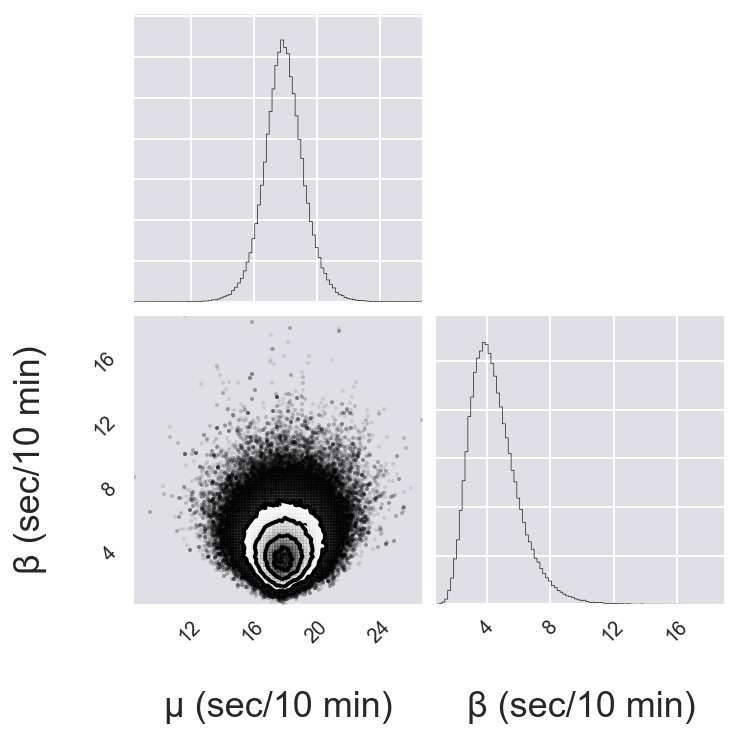

In [27]:
corner.corner(sampler.flatchain, labels=['µ (sec/10 min)', 'β (sec/10 min)'],
              bins=100);

We will assume the marginalized posterior of $\mu$ is roughly Gaussian distributed.  To check if it is, we can plot the ECDF of our samples alongside the CDF of a Gaussian with the same mean and standard deviation.

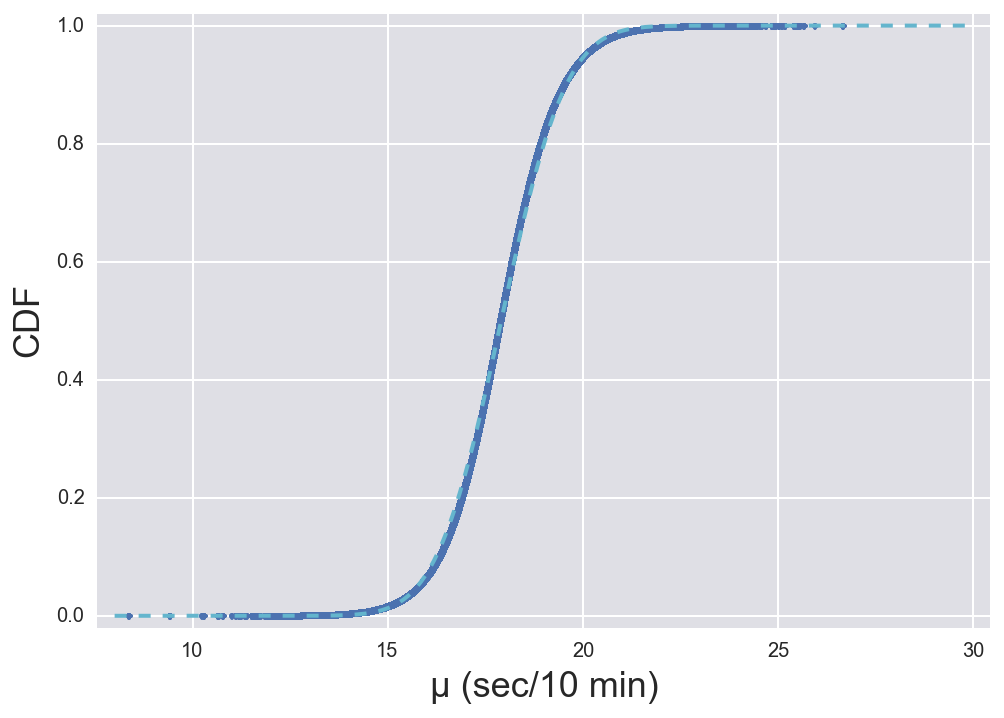

In [39]:
# Compute mean and standard deviation from traces
mu_mean = sampler.flatchain[:,0].mean()
mu_std = sampler.flatchain[:,0].std()

# Make ECDF
x = np.sort(sampler.flatchain[:,0])
y = np.arange(1, len(x)+1) / len(x)

# Make Gaussian CDF
x_plot = np.linspace(8, 30, 200)
y_gauss = st.norm.cdf(x_plot, mu_mean, mu_std)

# Make plot
plt.plot(x, y, '.')
plt.plot(x_plot, y_gauss, '--', color=sns.color_palette()[5])
plt.margins(0.02)
plt.xlabel('µ (sec/10 min)')
plt.ylabel('CDF')

The posterior is quite close to being Gaussian, so we can report a mean and error bar based on directly computing the mean and standard deviation from our samples.  We can also compare using the Gaussian likelihood.

In [40]:
# Mean and SEM from Gaussian likelihood
mean_gauss = mean_night_act['activity'].mean()
sem_gauss = mean_night_act['activity'].std() / len(mean_night_act)

# Mean and SEM from Cauchy likelihood (std calc. assumes approx. Gaussian)
mean_cauchy = mu_mean
sem_cauchy = mu_std

print("""
Gaussian likelihood: {0:.5f} +- {1:.5f} µm
Cauchy likelihood:   {2:.5f} +- {3:.5f} µm
""".format(mean_gauss, sem_gauss, mean_cauchy, sem_cauchy))


Gaussian likelihood: 30.57955 +- 1.60417 µm
Cauchy likelihood:   17.90618 +- 1.30512 µm



The mean computed using the Cauchy method is considerably lower (and it has a smaller error bar, though this will not always be the case).  Remember, these are the results, *given that our model 3 is true*, i.e., that the data are Cauchy distributed.  That is, they are distributed in a single peak that has long tails.  

Let's make a plot again to see it qualitatively.

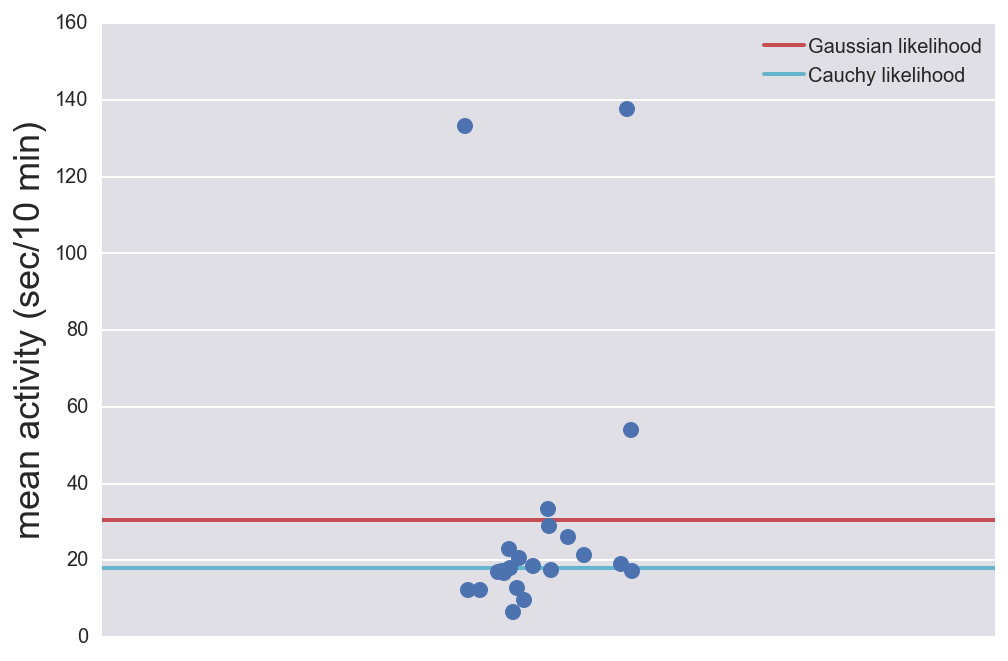

In [46]:
sns.stripplot(y='activity', data=mean_night_act, jitter=True)
plt.plot(plt.gca().get_xlim(), [naive_mean, naive_mean], '-',
         color=sns.color_palette()[2], label='Gaussian likelihood')
plt.plot(plt.gca().get_xlim(), [mean_cauchy, mean_cauchy], '-',
         color=sns.color_palette()[5], label='Cauchy likelihood')
plt.ylabel('mean activity (sec/10 min)')
plt.legend();

The Cauchy likelihood seems to have effectively dealt with the outliers.

## The good-and-bad data method

This section is heavily based on [this superb blog post](http://jakevdp.github.io/blog/2014/06/06/frequentism-and-bayesianism-2-when-results-differ/) from Jake VanderPlas, which is a nice implementation of the good-and-bad data model from section 8.3.2 of Sivia.

Let's assume for a moment that each datum can be good or bad.  We'll say that good data have an error bar of $\sigma$, and bad data have an error bar of $\sigma_\mathrm{bad}$.  Datum $i$ has a probability $g_i$ of being good.  Along with our mathematical model (all data should have a value of $\mu$), we have our model for the data and we can write the posterior.  We'll start by writing the likelihood.

\begin{align}
P(\{a_i\} \mid \mu, \sigma, \sigma_\mathrm{bad},\{g_i\}, I) &=
(2\pi)^{-n/2}\prod_i\left(
\frac{g_i}{\sigma}\,\mathrm{e}^{-(a_i-\mu)^2/2\sigma^2}
+ \frac{1-g_i}{\sigma_\mathrm{bad}}\,\mathrm{e}^{-(a_i - \mu)^2/2\sigma_\mathrm{bad}^2}
\right).
\end{align}

Then, the log posterior, assuming Jeffreys priors for $\sigma$ and $\sigma_\mathrm{bad}$ is

\begin{align}
\ln P(\mu, \sigma, \sigma_\mathrm{bad},\{g_i\} \mid \{a_i\},I) &= \text{constant}
- \ln\sigma - \ln \sigma_\mathrm{bad} \\[1em]
&\;\;\;\;- \sum_i\ln \left(\frac{g_i}{\sigma}\,\mathrm{e}^{-(a_i-\mu)^2/2\sigma^2}
+ \frac{1-g_i}{\sigma_\mathrm{bad}}\,\mathrm{e}^{-(a_i - \mu)^2/2\sigma_\mathrm{bad}^2}\right).
\end{align}

Note that this means we have a parameter, $g_i$ for every data point!  We have more parameters than data.  This might freak you out.  It shouldn't.  There is no problem with this.  We will properly marginalize everything out.

We note that the fact that $0\le g_i\le 1$ is encoded in the priors for $g_i$ and that $\sigma_\mathrm{bad} > \sigma$ is encoded in the prior for $\sigma$ and $\sigma_\mathrm{bad}$.

When we code up the log posterior, we need to be careful of numerical precision issues when computing the sum of the exponentials.  It is better to take the logs of the exponentials and then  use NumPy's `logaddexp` to do take the log of the sum of the exponentials.

In [48]:
def log_posterior_good_bad(p, x):
    """
    The log posterior for the good/bad data model for repeated
    measurements.
    """
    # Pull out parameters
    mu, sigma, sigma_bad = p[:3]
    g = p[3:]
    
    # Check to make sure the prior conditions are ok
    if (g < 0.0).any() or (g > 1.0).any() or sigma <= 0.0 \
            or sigma_bad < sigma:
        return -np.inf
    
    # log prior
    log_prior = -np.log(sigma) - np.log(sigma_bad)
    
    # Add in likelihood
    log_like_good = np.log(g / sigma) - ((x - mu) / sigma)**2 / 2.0
    log_like_bad = np.log((1.0 - g) / sigma_bad) \
                        - ((x - mu) / sigma_bad)**2 / 2.0
    log_like = np.logaddexp(log_like_good, log_like_bad).sum()
    
    # Return the whole posterior
    return log_prior + log_like

Now that we have our log posterior, we can run the MCMC calculation.

In [66]:
# Set up MCMC parameters
n_dim = 3 + len(mean_night_act) # number of parameters in the model
n_walkers = 100                 # number of MCMC walkers
n_burn = 2000                   # "burn-in" period to let chains stabilize
n_steps = 100000                # number of MCMC steps to take after burn-in

# Seed random number generator for reproducibility
np.random.seed(42)

# Generate random starting points for walkers.  
# p0[i,j] is the starting point for walk i along variable j.
p0 = np.empty((n_walkers, n_dim))
p0[:,0] = np.random.uniform(10, 30, n_walkers)               # mu
p0[:,1] = np.random.exponential(5.0, n_walkers)              # sigma
p0[:,2] = np.random.exponential(20.0, n_walkers)             # sigma_bad
p0[:,3:] = np.random.uniform(0.0, 1.0, (n_walkers, n_dim-3)) # g_i

# Set up the EnsembleSampler instance
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior_good_bad, 
                                args=(mean_night_act['activity'],), threads=6)

# Do the burn-in
pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)

# Reset sampler and run from the burn-in state we got to
_ = sampler.run_mcmc(pos, n_steps)

That took some work, so now let's see what we got.

In [79]:
# Get most probable parameter value
max_ind = np.argmax(sampler.flatlnprobability)
mean_goodbad = sampler.flatchain[max_ind,0]

# Get the error bar
sem_goodbad = sampler.flatchain[:,0].std()

# Report results
print("""
Gaussian likelihood: {0:.2f} ± {1:.2f} sec/10 min
Cauchy likelihood:   {2:.2f} ± {3:.2f} sec/10 min
Good/bad data model: {4:.2f} ± {5:.2f} sec/10 min
""".format(mean_gauss, sem_gauss, mean_cauchy, sem_cauchy, 
           mean_goodbad, sem_goodbad))


Gaussian likelihood: 30.58 ± 1.60 sec/10 min
Cauchy likelihood:   17.91 ± 1.31 sec/10 min
Good/bad data model: 18.09 ± 1.68 sec/10 min



The good/bad data model and the Cauchy model gave very close to the same results.  We can't really tell the difference if we plot them.

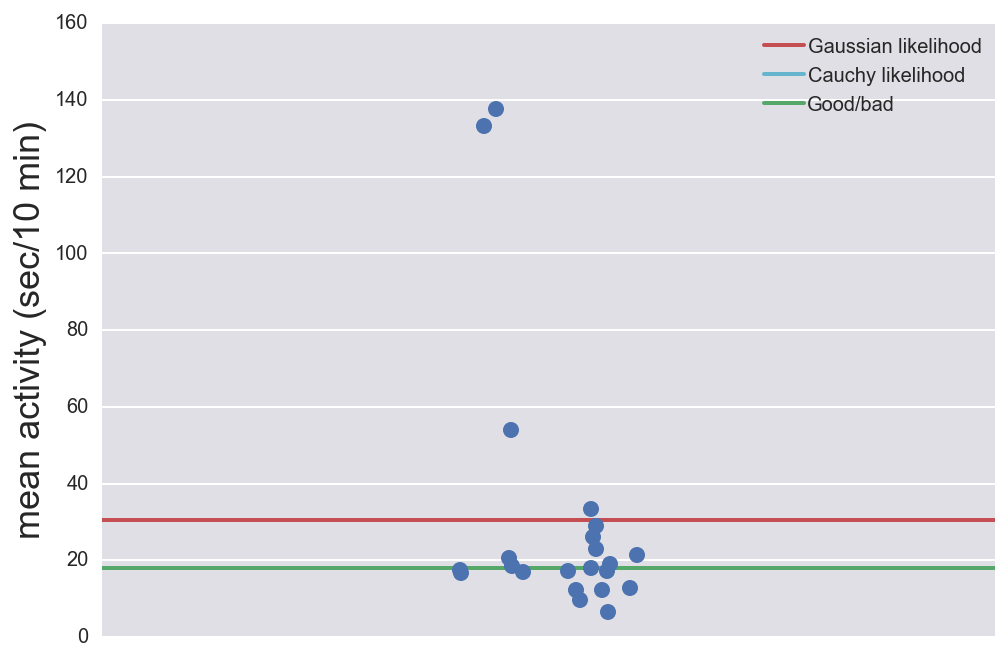

In [81]:
sns.stripplot(y='activity', data=mean_night_act, jitter=True)
plt.plot(plt.gca().get_xlim(), [naive_mean, naive_mean], '-',
         color=sns.color_palette()[2], label='Gaussian likelihood')
plt.plot(plt.gca().get_xlim(), [mean_cauchy, mean_cauchy], '-',
         color=sns.color_palette()[5], label='Cauchy likelihood')
plt.plot(plt.gca().get_xlim(), [mean_goodbad, mean_goodbad], '-',
         color=sns.color_palette()[1], label='Good/bad')
plt.ylabel('mean activity (sec/10 min)')
plt.legend();

A nice feature of the good/bad data model is that we can identify outliers.  Let $\bar{g}$ be the average goodness of data and $\sigma_g$ to be the standard deviation of goodness of data across all data points.  Then, we'll denote a bad data point to be one where $g_i < \bar{g} - 2\sigma_g$.

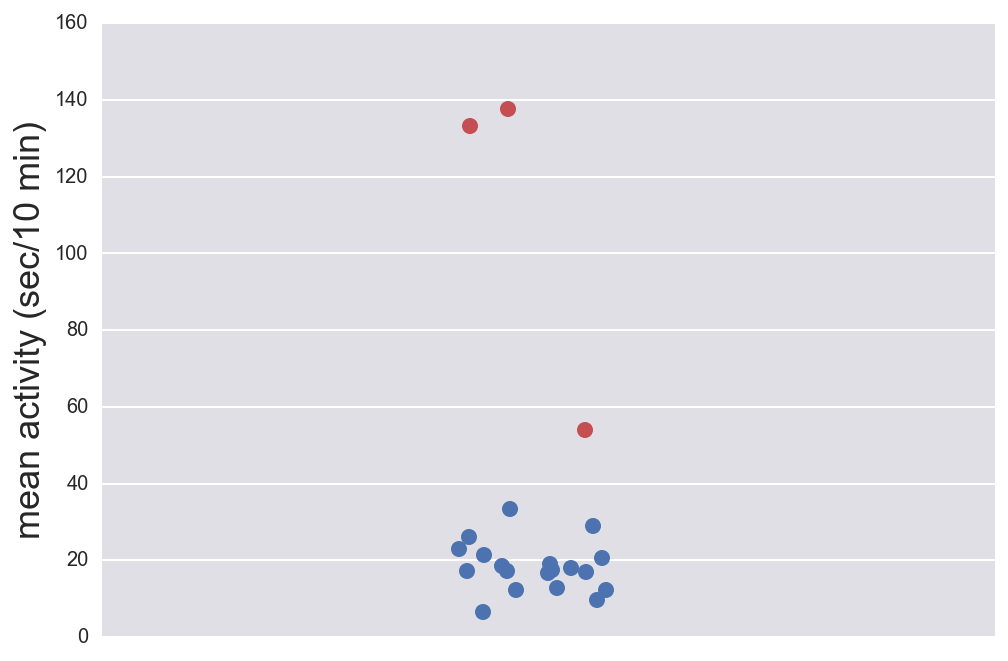

In [87]:
# Compute mean goodness of data
g = sampler.flatchain[:,3:].mean(axis=0)

# Identify outliers
outliers = (g < g.mean() - 2*g.std())

# Make strip plot with outliers in red
sns.stripplot(y='activity', data=mean_night_act[~outliers], jitter=True)
sns.stripplot(y='activity', data=mean_night_act[outliers], jitter=True, 
              color=sns.color_palette()[2])
plt.ylabel('mean activity (sec/10 min)')

Finally, we can look at the distributions of $\mu$, $\sigma$, and $\sigma_\mathrm{bad}$ to get a feel for how these parameters are distributed.  All units on the axes are seconds/10 minutes.

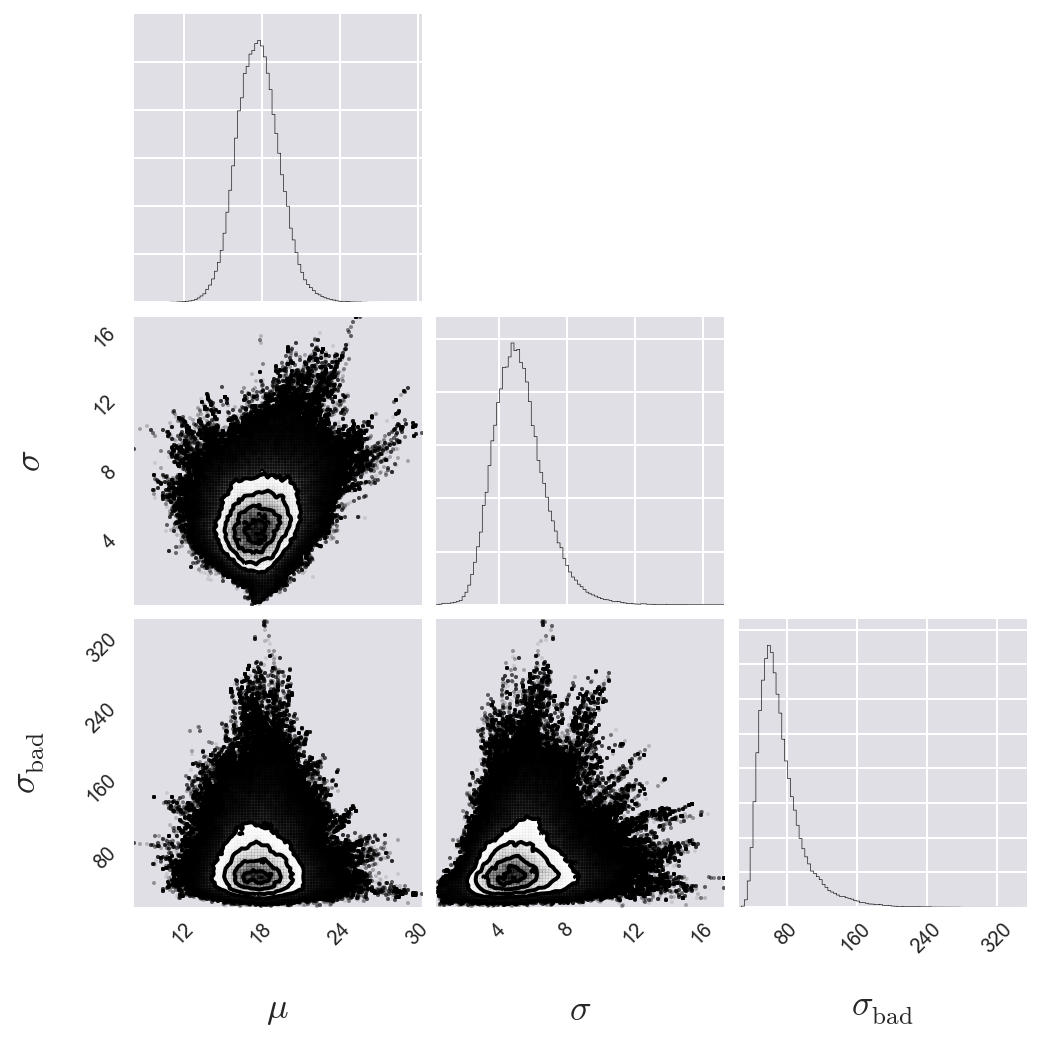

In [88]:
corner.corner(sampler.flatchain[:,:3], 
              labels=[r'$\mu$', r'$\sigma$', r'$\sigma_\mathrm{bad}$'],
              bins=100);

So, $\sigma_\mathrm{bad}$ is quite large.  We also get that $\mu$ is tightly distributed around 18 sec/10 min, indicating that the effect of the outliers was mitigated.

## Extension to regression
Both the Cauchy and good/bad data methods are easily extended to work with regressions.  In both methods, we simply replace $\mu$ in the likelihood whatever "model 2" function we choose.  The principles are the same, and in this case, the execution is also nearly identical.